<a href="https://colab.research.google.com/github/maribecrurod-art/Bootstrap-Proyect/blob/main/Red_bayesiana_flechas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se busca encontrar variables que explique la manera en la que se clasifica una flecha binaria, estas serán:

- EtiquetaVerdadera (ARRIBA, ABAJO, etc.)

- NivelRuido (Bajo, Medio, Alto)

- CompletitudTrazo (Alta, Media, Baja)

- Traslacion (Centrada, Desplazada)

Mediante esta se explicará que tipo de flecha es, esto basado en el conteo depixeles y su posición:

In [ ]:
!pip install pgmpy pandas numpy scipy matplotlib scikit-learn seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.ndimage import center_of_mass, shift
import io
import sys

In [ ]:
# Para la Red Bayesiana
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

In [ ]:

# Para evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
#Definición de flechas originales para el problema
# ----------------------------------
# Plantillas de Flechas Base
# ----------------------------------
print("\n--- 3. Mostrando plantillas de flechas base ---")

# Etiquetas en español
labels_map = {
    "ARRIBA": 0,
    "ABAJO": 1,
    "IZQUIERDA": 2,
    "DERECHA": 3
}
labels_list = list(labels_map.keys())

def arrow_up_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    A[0,4] = 1; A[1,3:6] = 1; A[2,2:7] = 1; A[3:,4] = 1
    return A

def arrow_down_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    A[8,4] = 1; A[7,3:6] = 1; A[6,2:7] = 1; A[:6,4] = 1
    return A

def arrow_left_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    A[4,0] = 1; A[3:6,1] = 1; A[2:7,2] = 1; A[4,3:] = 1
    return A

def arrow_right_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    A[4,8] = 1; A[3:6,7] = 1; A[2:7,6] = 1; A[4,:6] = 1
    return A



--- 3. Mostrando plantillas de flechas base ---


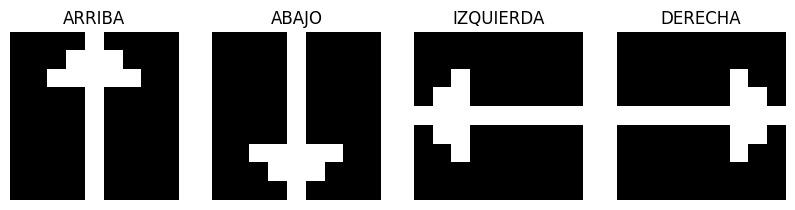

In [ ]:

# Visualización de prueba
plantillas = [arrow_up_9x9(), arrow_down_9x9(), arrow_left_9x9(), arrow_right_9x9()]
fig, axs = plt.subplots(1,4, figsize=(10,3))
for i, A in enumerate(plantillas):
    axs[i].imshow(A, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(labels_list[i])
    axs[i].axis('off')
plt.show()

In [ ]:
# ----------------------------------
#  Funciones de Simulación (Aumento)
# ----------------------------------

def aplicar_ruido_sal_pimienta(imagen, p_ruido):
    """Aplica ruido 'sal y pimienta' (invierte bits)."""
    img_ruidosa = imagen.copy()
    num_pixeles_ruido = int(np.floor(p_ruido * imagen.size))

    for _ in range(num_pixeles_ruido):
        x, y = random.randint(0, 8), random.randint(0, 8)
        img_ruidosa[x, y] = 1 - img_ruidosa[x, y] # Invertir el píxel
    return img_ruidosa

def aplicar_traslacion_simple(imagen, shift_xy):
    """Aplica un shift simple."""
    # shift usa (y, x)
    return shift(imagen, (shift_xy[1], shift_xy[0]), cval=0, order=0)

def aplicar_completitud(imagen, p_completitud):
    """Elimina píxeles '1' para simular trazo incompleto."""
    if p_completitud == 1.0:
        return imagen

    img_incompleta = imagen.copy()
    indices_pixeles_activos = np.argwhere(img_incompleta == 1)

    for idx in indices_pixeles_activos:
        if random.random() > p_completitud:
            img_incompleta[tuple(idx)] = 0
    return img_incompleta

print("--- Funciones de simulación definidas ---")

--- 4. Funciones de simulación definidas ---


In [ ]:

# ----------------------------------
# Funciones de Extracción de Características
# ----------------------------------

def extraer_conteo_pixeles(imagen):
    """Observable 1: Conteo total de píxeles activos."""
    return np.sum(imagen)

def extraer_posicion_y(imagen):
    """Observable 2: Posición Y (vertical) del centro de masa."""
    # Si la imagen está vacía (por ruido/completitud), el centro es (0,0)
    if np.sum(imagen) == 0:
        return 4.0 # Retornar el centro por defecto

    # center_of_mass retorna (y, x)
    # Un valor bajo (0-2) es 'Superior', (3-5) 'Central', (6-8) 'Inferior'
    cm = center_of_mass(imagen)
    return cm[0]

print("--- Funciones de extracción definidas ---")

--- Funciones de extracción definidas ---


In [ ]:
# ----------------------------------
#  Generación del Dataset Completo
# ----------------------------------
print("\n---  Generando dataset... ---")

def generar_dataset(n=2000, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    data = []

    # Probabilidades para los factores causales (latentes)
    prob_ruido = {"Bajo": 0.5, "Medio": 0.3, "Alto": 0.2}
    map_ruido = {"Bajo": 0.05, "Medio": 0.15, "Alto": 0.30} # p_ruido real

    prob_completitud = {"Alta": 0.7, "Media": 0.2, "Baja": 0.1}
    map_completitud = {"Alta": 1.0, "Media": 0.85, "Baja": 0.70} # p_completitud real

    prob_traslacion = {"Centrada": 0.6, "Desplazada": 0.4}
    map_traslacion = {"Centrada": (0,0), "Desplazada_Arriba": (0,-1), "Desplazada_Abajo": (0,1), "Desplazada_Izq": (-1,0), "Desplazada_Der": (1,0)}

    for i in range(n):

        # 1. Seleccionar Etiqueta Verdadera (Latente)
        etiqueta_verdadera = random.choice(labels_list)
        imagen_base = plantillas[labels_map[etiqueta_verdadera]].copy()

        # 2. Simular Factores Causales (Latentes)
        factor_ruido = np.random.choice(list(prob_ruido.keys()), p=list(prob_ruido.values()))
        factor_completitud = np.random.choice(list(prob_completitud.keys()), p=list(prob_completitud.values()))
        factor_traslacion = np.random.choice(list(prob_traslacion.keys()), p=list(prob_traslacion.values()))

        # 3. Aplicar transformaciones basadas en factores
        p_ruido_real = map_ruido[factor_ruido]
        p_completitud_real = map_completitud[factor_completitud]

        if factor_traslacion == "Centrada":
            shift_real = map_traslacion["Centrada"]
        else:
            shift_real = map_traslacion[random.choice(["Desplazada_Arriba", "Desplazada_Abajo", "Desplazada_Izq", "Desplazada_Der"])]


        img_transformada = aplicar_traslacion_simple(imagen_base, shift_real)
        img_transformada = aplicar_completitud(img_transformada, p_completitud_real)
        img_transformada = aplicar_ruido_sal_pimienta(img_transformada, p_ruido_real)

        # 4. Extraer Características Observables
        conteo_pixeles_obs = extraer_conteo_pixeles(img_transformada)
        posicion_y_obs = extraer_posicion_y(img_transformada)

        # 5. Guardar todo
        fila = {
            "EtiquetaVerdadera": etiqueta_verdadera,
            "NivelRuido": factor_ruido,
            "CompletitudTrazo": factor_completitud,
            "Traslacion": factor_traslacion,
            "ConteoPixeles_Num": conteo_pixeles_obs,
            "Posicion_Y_Num": posicion_y_obs,
        }
        data.append(fila)

    df = pd.DataFrame(data)

    # 6. Discretizar las observables
    bins_conteo = [-1, 10, 18, 81] # Rangos para (Bajo, Medio, Alto)
    labels_conteo = ["Bajo", "Medio", "Alto"]
    df["ConteoPixeles"] = pd.cut(df["ConteoPixeles_Num"], bins=bins_conteo, labels=labels_conteo, right=True)

    bins_pos_y = [-1, 2.9, 5.1, 9] # Rangos para (Superior, Central, Inferior)
    labels_pos_y = ["Superior", "Central", "Inferior"]
    df["Posicion_Y"] = pd.cut(df["Posicion_Y_Num"], bins=bins_pos_y, labels=labels_pos_y, right=True)

    # Asegurarse que todas las columnas categóricas sean 'category'
    for col in ["EtiquetaVerdadera", "NivelRuido", "CompletitudTrazo", "Traslacion", "ConteoPixeles", "Posicion_Y"]:
        df[col] = df[col].astype("category")

    return df.drop(columns=["ConteoPixeles_Num", "Posicion_Y_Num"])

# Generar el dataset
df = generar_dataset(n=3000)
print(f"Dataset generado con {len(df)} muestras.")
print(df.head())




---  Generando dataset... ---
Dataset generado con 3000 muestras.
  EtiquetaVerdadera NivelRuido CompletitudTrazo  Traslacion ConteoPixeles  \
0            ARRIBA       Bajo             Baja  Desplazada         Medio   
1         IZQUIERDA      Medio             Alta    Centrada          Alto   
2            ARRIBA       Bajo            Media  Desplazada         Medio   
3           DERECHA      Medio             Alta  Desplazada          Alto   
4             ABAJO       Alto             Alta    Centrada          Alto   

  Posicion_Y  
0   Superior  
1    Central  
2    Central  
3    Central  
4    Central  


In [ ]:
from pgmpy.models import DiscreteBayesianNetwork

# ----------------------------------
#  Definir y Ajustar la Red Bayesiana
# ----------------------------------
print("\n--- Definiendo y ajustando la Red Bayesiana ---")

dag_estructura = [
    ("EtiquetaVerdadera", "Posicion_Y"),
    ("Traslacion", "Posicion_Y"),
    ("EtiquetaVerdadera", "ConteoPixeles"),
    ("NivelRuido", "ConteoPixeles"),
    ("CompletitudTrazo", "ConteoPixeles")
]

nodos_modelo = ["EtiquetaVerdadera", "Traslacion", "NivelRuido", "CompletitudTrazo", "Posicion_Y", "ConteoPixeles"]
df_modelo = df[nodos_modelo]

df_train, df_test = train_test_split(df_modelo, test_size=0.2, random_state=42)

modelo_bn = DiscreteBayesianNetwork(dag_estructura)

# Silenciar warnings de pgmpy (opcional)
old_stderr = sys.stderr
sys.stderr = io.StringIO()
try:
    modelo_bn.fit(df_train, estimator=MaximumLikelihoodEstimator)
finally:
    sys.stderr = old_stderr

print("Modelo BN ajustado (fitted).")


--- Definiendo y ajustando la Red Bayesiana ---
Modelo BN ajustado (fitted).


In [ ]:
# ----------------------------------
#  Inferencia Causal
# ----------------------------------
print("\n---  Ejemplos de Inferencia ---")

inferencia = VariableElimination(modelo_bn)

# Ejemplo 1: Diagnóstico
print("--- Consulta 1 (Diagnóstico) ---")
print("P(Etiqueta | Posicion_Y=Superior, ConteoPixeles=Medio)")
q1 = inferencia.query(
    variables=["EtiquetaVerdadera"],
    evidence={
        "Posicion_Y": "Superior",
        "ConteoPixeles": "Medio"
    }
)
print(q1)

# Ejemplo 2: Sensibilidad
print("\n--- Consulta 2 (Sensibilidad) ---")
print("P(Posicion_Y | Traslacion=Desplazada, NivelRuido=Alto)")
q2 = inferencia.query(
    variables=["Posicion_Y"],
    evidence={
        "Traslacion": "Desplazada",
        "NivelRuido": "Alto"
    }
)
print(q2)


---  Ejemplos de Inferencia ---
--- Consulta 1 (Diagnóstico) ---
P(Etiqueta | Posicion_Y=Superior, ConteoPixeles=Medio)
+------------------------------+--------------------------+
| EtiquetaVerdadera            |   phi(EtiquetaVerdadera) |
+==============================+==========================+
| EtiquetaVerdadera(ABAJO)     |                   0.0000 |
+------------------------------+--------------------------+
| EtiquetaVerdadera(ARRIBA)    |                   0.8681 |
+------------------------------+--------------------------+
| EtiquetaVerdadera(DERECHA)   |                   0.0128 |
+------------------------------+--------------------------+
| EtiquetaVerdadera(IZQUIERDA) |                   0.1191 |
+------------------------------+--------------------------+

--- Consulta 2 (Sensibilidad) ---
P(Posicion_Y | Traslacion=Desplazada, NivelRuido=Alto)
+----------------------+-------------------+
| Posicion_Y           |   phi(Posicion_Y) |
+======================+===============


--- 9. Evaluación del Modelo (Precisión MAP) ---


  0%|          | 0/7 [00:00<?, ?it/s]

Precisión del Clasificador Bayesiano (MAP): 24.67%

Matriz de Confusión:


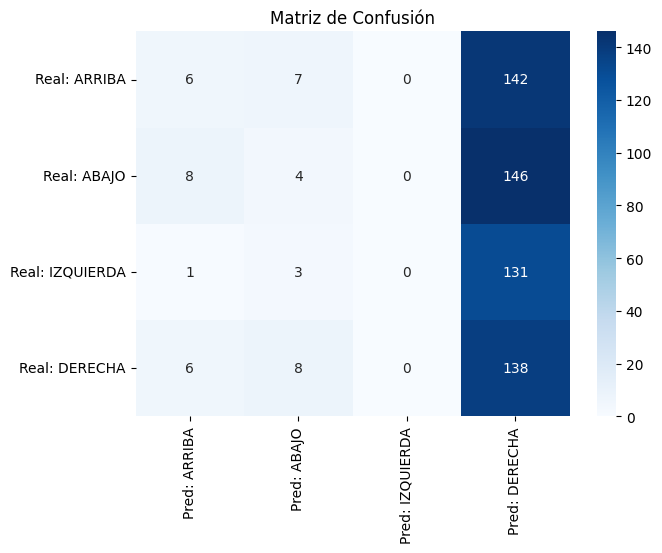


--- Fin del script. ---


In [ ]:
# ----------------------------------
#  Evaluación y Predicción (MAP)
# ----------------------------------
print("\n--- 9. Evaluación del Modelo (Precisión MAP) ---")

observables = ["Posicion_Y", "ConteoPixeles"]
a_predecir = ["EtiquetaVerdadera"]

df_test_observables = df_test[observables]

# Silenciar warnings de pgmpy (opcional)
old_stderr = sys.stderr
sys.stderr = io.StringIO()
try:
    predicciones = modelo_bn.predict(
        df_test_observables,
        n_jobs=1
    )
finally:
    sys.stderr = old_stderr


etiquetas_reales = df_test["EtiquetaVerdadera"]
etiquetas_predichas = predicciones["EtiquetaVerdadera"]

accuracy = accuracy_score(etiquetas_reales, etiquetas_predichas)
print(f"Precisión del Clasificador Bayesiano (MAP): {accuracy * 100:.2f}%\n")

print("Matriz de Confusión:")
cm = confusion_matrix(etiquetas_reales, etiquetas_predichas, labels=labels_list)
cm_df = pd.DataFrame(cm, index=[f"Real: {l}" for l in labels_list], columns=[f"Pred: {l}" for l in labels_list])

plt.figure(figsize=(7, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

print("\n--- Fin del script. ---")